In [89]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from constants_all import *
from pprint import pprint
STALL_BID_OFFSET = 1e6

In [3]:
train_data, test_data, _, bellman_ford = pickle.load(open(f"data/eval_datas_21_40_nofilter.pkl", "rb"))

In [4]:
waves = sum(train_data.values(), []) + sum(test_data.values(), [])
print(len(waves))

1695


In [76]:
def adjust_odr_seq(odrs, n_iter=1):
    """在按finish_time排序的基础上微调送单次序, 以去除反复横跳的噪声"""
    T_merge, T_change, T_pull, N_pull = 300, 300, 180, 5
    def get_b_os(odrs):
        b_os = [[odrs[0]["building_id"], [odrs[0]]]]  # 聚合bid相同且时间相邻的订单作为操作基本单元
        for o in odrs[1:]:
            if o["building_id"] == b_os[-1][0] and o["finish_time"] - b_os[-1][1][-1]["finish_time"] < T_merge:
                b_os[-1][1].append(o)
            else:
                b_os.append([o["building_id"], [o]])
        return b_os
    
    n_odrs = len(odrs)
    odrs.sort(key=lambda x: x["finish_time"])
    odrs_stall = [o for o in odrs if o["building_id"] >= STALL_BID_OFFSET]  # 先把摆摊的单拎出来不处理
    odrs = [o for o in odrs if o["building_id"] < STALL_BID_OFFSET]
    # 处理间隔1次重复访问的: 交换相邻两b_os的顺序, 看有没有增益
    for _ in range(n_iter):
        b_os = get_b_os(odrs)
        for i in range(len(b_os) - 3):
            a, b, c, d = b_os[i: i + 4]  # 尝试交换b,c的顺序, 使得交换之后同一楼能挨在一起
            if b[0] != c[0] and c[1][0]["finish_time"] - b[1][-1]["finish_time"] < T_change:
                if (a[0] == c[0]) + (b[0] == d[0]) > (a[0] == b[0]) + (c[0] == d[0]):
                    b_os[i+1], b_os[i+2] = b_os[i+2], b_os[i+1]
        odrs = sum([x[1] for x in b_os], [])
    # 处理间隔>1次重复访问的: 访问1栋楼的后T_pull时间内访问了同一栋楼, 若间隔的楼数<N_pull, 就强行拉到身边来
    b_os = get_b_os(odrs)
    i = 0
    while i < len(b_os):
        bi = b_os[i][0]
        for j in range(i+1, len(b_os)):  # j为之后第一个不为bi的索引
            if b_os[j][0] != bi:
                break
        else:
            break
        ti = b_os[j - 1][1][-1]["finish_time"]

        idxs_pull = []
        gap = 0
        for k in range(j, len(b_os)):
            bk, osk = b_os[k]
            if bk == bi:
                if osk[0]["finish_time"] - ti < T_pull:
                    idxs_pull.append(k)
                else:
                    break
            else:
                gap += 1
            if gap == N_pull:
                break
        if idxs_pull:
            b_os = b_os[:j] + [b_os[k] for k in idxs_pull] + [b_os[k] for k in range(j, len(b_os)) if k not in idxs_pull]
            i = j + len(idxs_pull)
        else:
            i += 1

    odrs = sum([x[1] for x in b_os], [])
    if odrs_stall:  # 把摆摊点的单打包插入到时间最近的地方
        t = odrs_stall[0]["finish_time"]
        for i, o in enumerate(odrs):
            if o["finish_time"] > t:
                break
        odrs = odrs[:i] + odrs_stall + odrs[i:]
    assert len(odrs) == n_odrs
    return odrs

In [78]:
vs = []       # 每次在楼间转移时的速度
bid_ni_nos = []   # 存在多个单的楼, 被访问的次数-单数
jump_is = []  # 多次访问同一楼时, 间隔了多少楼
jump_ts = []  # 多次访问同一楼时, 间隔的时长
for w in waves:
    odrs = adjust_odr_seq(w["orders"], n_iter=2)
    b2odrs = group_by(odrs, "building_id")
    b2it = {}
    last_b, t = odrs[0]["building_id"], odrs[0]["finish_time"]
    i = 0
    b2it[last_b] = [[i, [t, t]]]  # 记录每栋楼被多次访问的 次序, 最早时间,最晚时间
    for o in odrs[1:]:
        b, t = o["building_id"], o["finish_time"]
        if b == last_b:
            b2it[b][-1][1][1] = t
        else:
            i += 1
            l = bellman_ford[str(last_b)][str(b)]
            v = l / (t - b2it[last_b][-1][1][1] + 1e-12)
            vs.append(v)
            if b in b2it:
                b2it[b].append([i, [t, t]])
            else:
                b2it[b] = [[i, [t, t]]]
            last_b = b
    for b, its in b2it.items():
        no = len(b2odrs[b])
        if no > 1:
            bid_ni_nos.append([b, len(its), no])
        for (i1, (ts1, te1)), (i2, (ts2, te2)) in zip(its, its[1:]):
            assert i2 > i1 + 1
            jump_is.append(i2 - i1 - 1)
            jump_ts.append(ts2 - te1)
ni_nos = [x[1:] for x in bid_ni_nos]

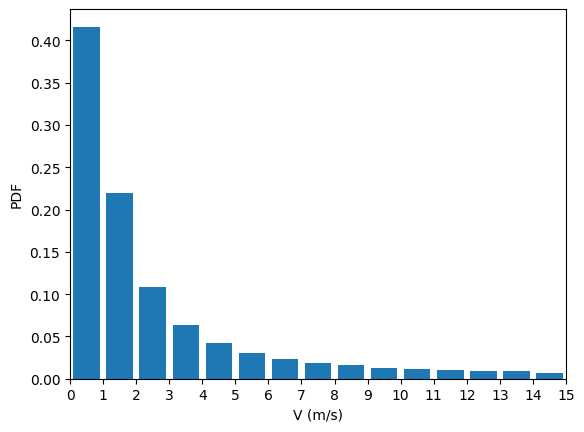

In [79]:
plt.figure()
x_min, x_max, tick, step = 0, 15, 1, 1
plt.ylabel("PDF")
plt.xlabel("V (m/s)")
plt.xlim((x_min, x_max))
plt.gca().xaxis.set_major_locator(MultipleLocator(tick))
plt.hist(x=vs, bins=range(x_min, x_max + 1, step), histtype='bar', rwidth=0.8, density=True, cumulative=False)
plt.show()

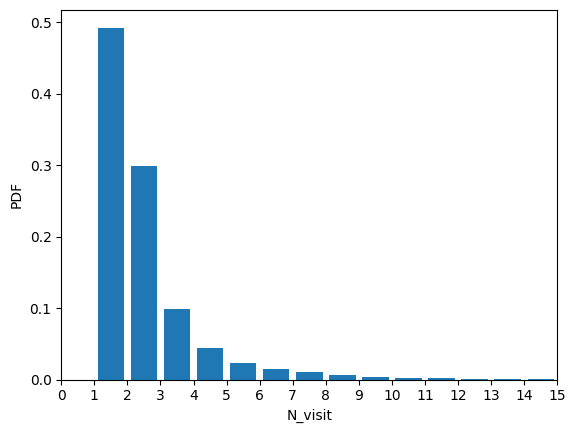

In [72]:
plt.figure()
x_min, x_max, tick, step = 0, 15, 1, 1
plt.ylabel("PDF")
plt.xlabel("N_visit")
plt.xlim((x_min, x_max))
plt.gca().xaxis.set_major_locator(MultipleLocator(tick))
plt.hist(x=[x[0] for x in ni_nos], bins=range(x_min, x_max + 1, step), histtype='bar', rwidth=0.8, density=True, cumulative=False)
plt.show()

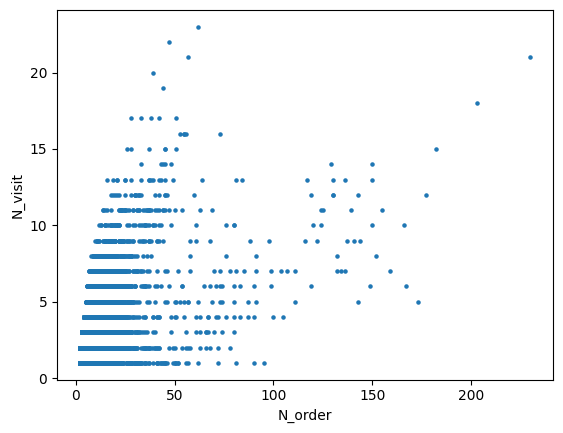

In [73]:
plt.figure()
plt.ylabel("N_visit")
plt.xlabel("N_order")
nis, nos = zip(*ni_nos)
plt.scatter(x=nos, y=nis, s=5)
plt.show()

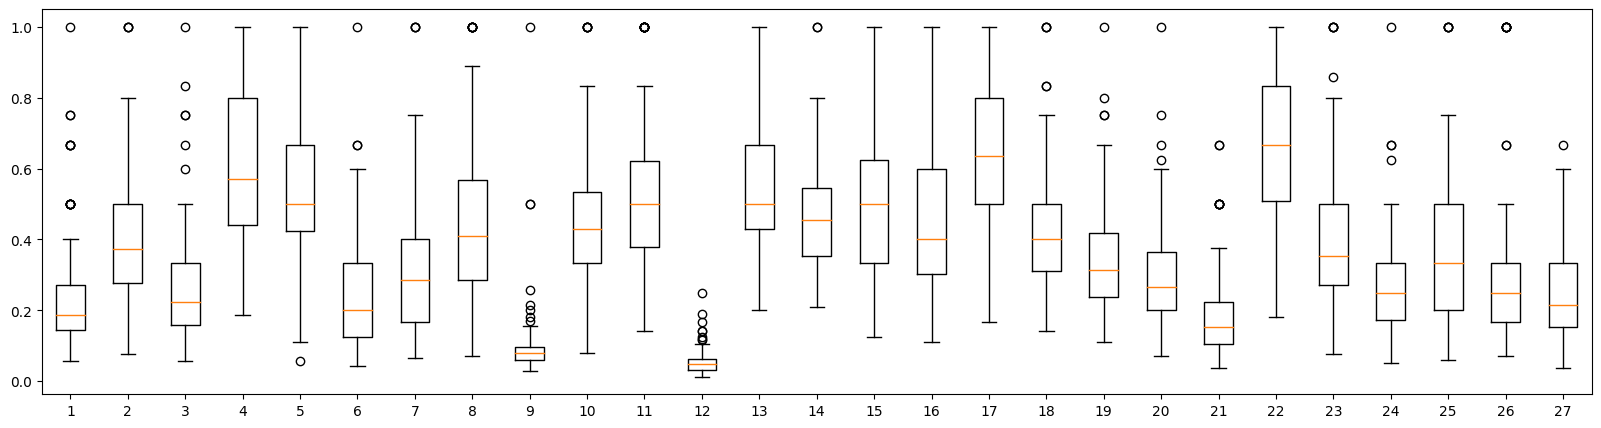

In [93]:
# 每栋楼在不同波中, ni/no的比值分布
bid2ni_nos = defaultdict(list)
for bid, ni, no in bid_ni_nos:
    bid2ni_nos[bid].append([ni, no])
bid2ni_nos = {k: v for k, v in bid2ni_nos.items() if len(v) > 110}
bid2ps = {bid: [ni / no for ni, no in ni_nos] for bid, ni_nos in bid2ni_nos.items()}
plt.figure(figsize=(20, 5))
plt.boxplot(bid2ps.values())
plt.show()

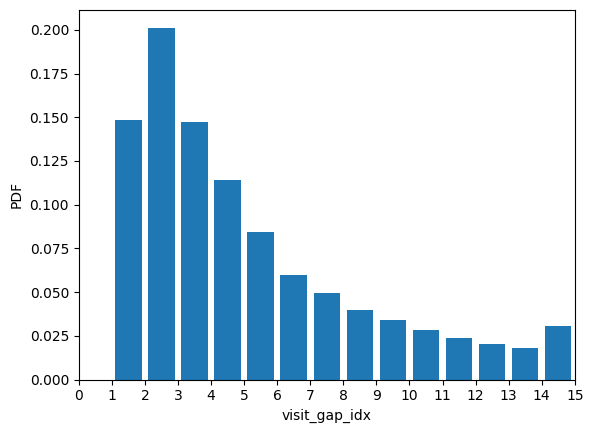

In [74]:
plt.figure()
x_min, x_max, tick, step = 0, 15, 1, 1
plt.ylabel("PDF")
plt.xlabel("visit_gap_idx")
plt.xlim((x_min, x_max))
plt.gca().xaxis.set_major_locator(MultipleLocator(tick))
plt.hist(x=jump_is, bins=range(x_min, x_max + 1, step), histtype='bar', rwidth=0.8, density=True, cumulative=False)
plt.show()

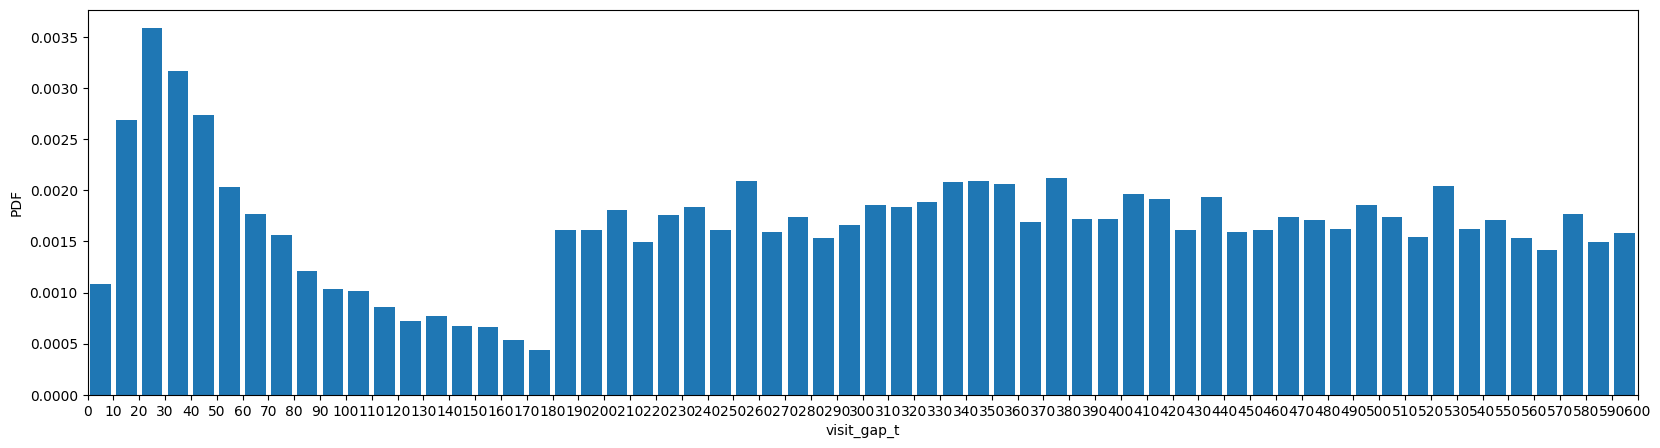

In [75]:
plt.figure(figsize=(20, 5))
x_min, x_max, tick, step = 0, 600, 10, 10
plt.ylabel("PDF")
plt.xlabel("visit_gap_t")
plt.xlim((x_min, x_max))
plt.gca().xaxis.set_major_locator(MultipleLocator(tick))
plt.hist(x=jump_ts, bins=range(x_min, x_max + 1, step), histtype='bar', rwidth=0.8, density=True, cumulative=False)
plt.show()